# Pressure-velocity boundary conditions for cavity flow

This section looks at cavity flow again, but with a recalibration of the pressure boundary conditions.

The Navier-Stokes equations in two dimensions, momentum and the Poisson pressure equation, are:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right)$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

Again, we assume that the current flow field is not divergence-free in the numerical schemes: $\nabla \bf u^{n+1/2} \neq 0$, so this assumption is used to calculate the pressure field:

$$\nabla^2 p^{n+1}=\frac{\rho}{\Delta t}\nabla\cdot\bf{u}^{n+1/2}-\rho\left(\left(\frac{\partial u}{\partial x}\right)^2+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\left(\frac{\partial u}{\partial y}\right)^2\right)$$

which is the Poisson pressure equation, but maintaining the numerical divergence term that is zero in the continuous formulation. This discretizes as:

$$
\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2*p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} 
=\rho\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)\right.-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}
- \ 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}
-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\quad 
$$


## Pressure boundary conditions

The pressure boundary conditions will be carefully evaluated. The NS momentum equation can be written as:

$$ \nabla p= \rho \left( -\frac{\partial{\bf{u}}}{\partial t}-\bf{u}\cdot\nabla\bf{u}+\nu\nabla^2\bf{u}\right)\quad$$

If we take the dot product of each side with a normal vector of the boundary, we obtain:

$$\bf{n}\cdot\nabla p=\rho \bf{n}\cdot\left( -\frac{\partial{\bf u}}{\partial t} -\bf{u}\cdot\nabla\bf{u}+\nu\nabla^2\bf{u}\right)\quad$$

For a rigid boundary, the velocity at the boundary is zero. On the $y=0$ boundary, for example, this would give:

$$\hat{\bf j}\cdot\left(\frac{\partial p}{\partial x}\hat{\bf i} + \frac{\partial p}{\partial y}\hat{\bf j}\right) = \rho\hat{\bf j}\cdot\left(-\frac{\partial u}{\partial t}\hat{\bf i} - \frac{\partial v}{\partial t} \hat{\bf j} - \left(u\hat{\bf i} + v\hat{\bf j}\right)\cdot\left(\frac{\partial u}{\partial x}\hat{\bf i} + \frac{\partial v}{\partial y}\hat{\bf j}\right) + \nu\left(\frac{\partial^2 u}{\partial x^2}\hat{\bf i} + \frac{\partial^2 v}{\partial y^2}\hat{\bf j}\right)\right)$$ 

Assuming steady flow, the above equation simplifies to:

$$\frac{\partial p}{\partial y} = \rho\nu\frac{\partial^2 v}{\partial y^2}$$

So, there may be a pressure gradient on a rigid boundary, depending on the curvature of the velocity field in space there.

To find the pressure gradient on the boundary, we must find the second derivative of the velocity on the boundary. The normal central difference scheme is problematic there, because it requires evaluation past the boundary. Instead, we can use the scheme:

$$\left.\frac{\partial^2 v}{\partial y^2}\right|_{i,j=0}=\frac{1}{\Delta y^2}\left(v_{i,j=0}-2 v_{i,j=1}+v_{i,j=2}\right)$$


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def pressPoisson(p, dx, dy, dt, rho, nu, u, v, nit):
    import numpy as np
    pn = np.empty_like(p)
    b = np.empty_like(p)
    
    # For readibility, the term in square brackets is below
    b[1:-1,1:-1] = (1/dt * ((u[1:-1,2:]-u[1:-1,:-2])/(2*dx) + (v[2:,1:-1]-v[:-2,1:-1])/(2*dy))
                    - ((u[1:-1,2:]-u[1:-1,:-2])/(2*dx))**2
                    - ((v[2:,1:-1]-v[:-2,1:-1])/(2*dy))**2
                    - 2 * (u[2:,1:-1]-u[:-2,1:-1])/(2*dy) * (v[1:-1,2:]-v[1:-1,:-2])/(2*dx))
    
    for n in range(nit):
        pn = np.copy(p)
        p[1:-1,1:-1] = (((pn[1:-1,2:]+pn[1:-1,:-2])*dy**2 + (pn[2:,1:-1]+p[:-2,1:-1])*dx**2)/(2*(dx**2+dy**2))
                        - rho*dx**2*dy**2/(2*(dx**2+dy**2)) * b[1:-1,1:-1])
        # Boundary conditions
        ## at y = Ly (free surface)
        ## The position of the centered second difference makes the pressure be a forward difference, aka (p[-2] - p[-1])/dy
        p[-1,:] = p[-2,:] - rho*nu/dy*(v[-1,:]-2*v[-2,:]+v[-3,:])
        ## at y = 0 (bottom)
        ## This creates a backward difference for the pressure derivative, (p[1] - p[0])/dy
        p[0,:] = p[1,:] - rho*nu/dy*(v[0,:]-2*v[1,:]+v[2,:])
        ## at x = 0 (left)
        ## This is a backward difference for pressure (p[1] - p[0])/dx
        p[:,0] = p[:,1] - rho*nu/dx*(u[:,0]-2*u[:,1]+u[:,2])
        ## at x = Lx (right)
        ## This is a forward difference, (p[-2] - p[-1])/dx
        p[:,-1] = p[:,-2] - rho*nu/dx*(u[:,-1]-2*u[:,-2]+u[:,-3])
    return p

In [3]:
def cavity_flow():
    import numpy as np
    nx = 51
    ny = 51
    nt = 5000
    nit = 50
    Uwall = 1.
    Lx = 2
    Ly = 2
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    rho = 1
    nu = 0.02
    dt = 0.002
    
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    
    for n in range(nt):
        un = np.copy(u)
        vn = np.copy(v)
        p = pressPoisson(p, dx, dy, dt, rho, nu, u, v, nit)
        
        u[1:-1,1:-1] = (un[1:-1,1:-1] - un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,:-2])
                       - vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[:-2,1:-1])
                       - dt/(2*rho*dx)*(p[1:-1,2:]-p[1:-1,:-2])
                       + nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,:-2])
                            + dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[:-2,1:-1])))
        
        v[1:-1,1:-1] = (vn[1:-1,1:-1] - un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,:-2])
                       - vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[:-2,1:-1])
                       - dt/(2*rho*dy)*(p[2:,1:-1]-p[:-2,1:-1])
                       + nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,:-2])
                            + dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[:-2,1:-1])))

        # Boundary conditions
        u[0,:] = 0         # y = 0
        v[0,:] = 0         # y = 0
        u[-1,:] = Uwall    # y = Ly
        v[-1,:] = 0        # y = Ly
        u[:,0] = 0         # x = 0
        v[:,0] = 0         # x = 0
        u[:,-1] = 0        # x = Lx
        v[:,-1] = 0        # x = Lx
    return u, v, p, X, Y

In [6]:
def plot_cavity():
    import matplotlib.pyplot as plt
    from matplotlib import cm 
    u, v, p, X, Y = cavity_flow()
    fig = plt.figure(figsize=(11,7))
    plt.contourf(X, Y, p, alpha=0.5)     # Pressure field as contour
    plt.colorbar()
    plt.contour(X, Y, p)
    plt.quiver(X, Y, u, v)               # Velocity
    plt.xlabel('X')
    plt.ylabel('Y')

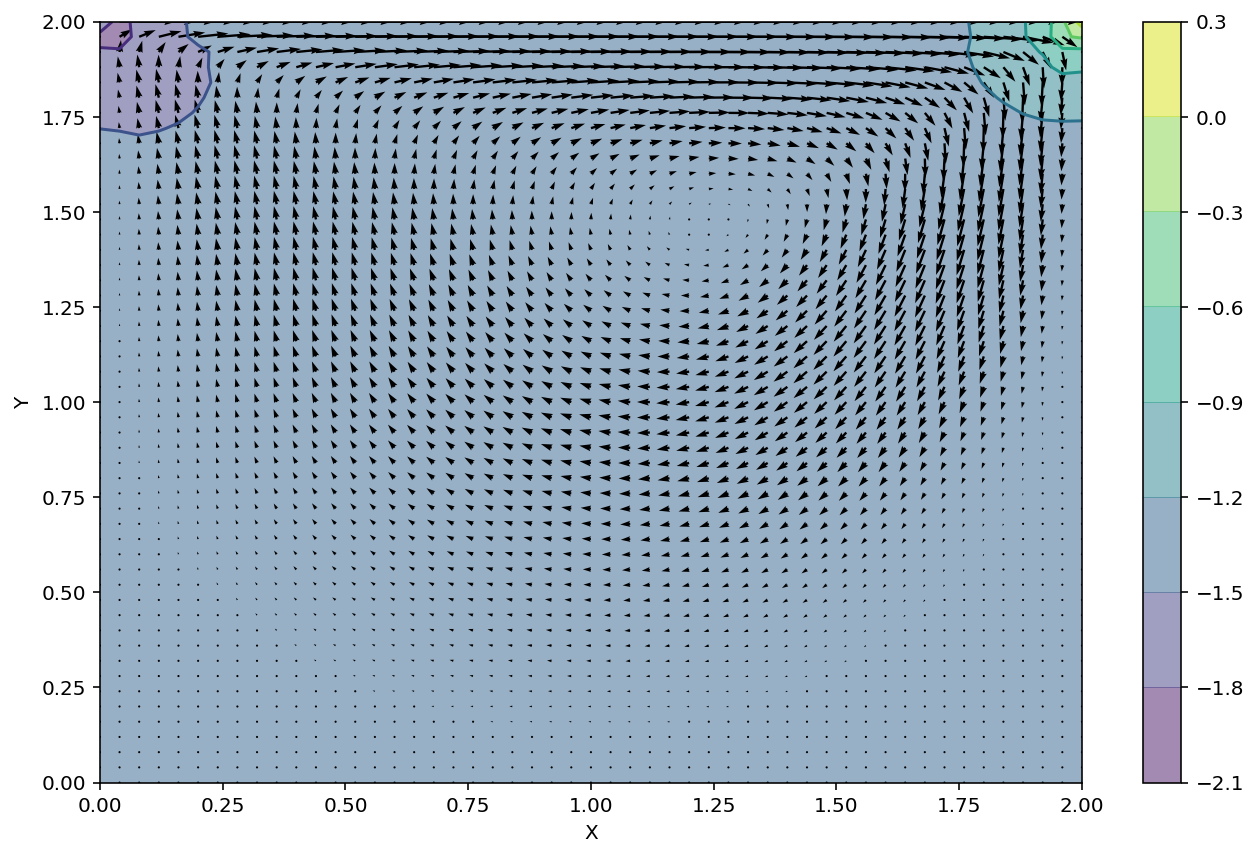

In [7]:
plot_cavity()